In [1]:
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(x_val.shape)

(15407, 60, 9)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


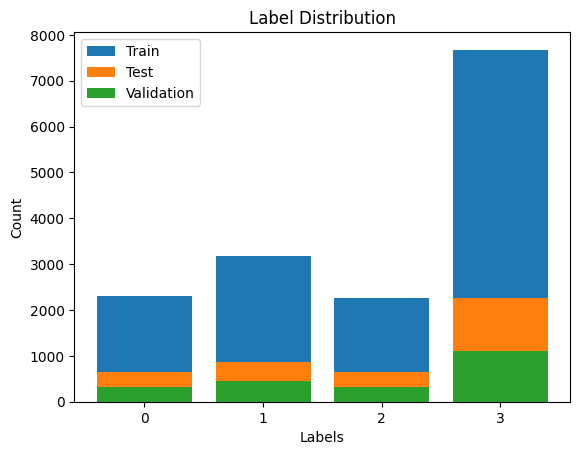

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_type, dataset_ver):
        self.X = np.array(np.load(f'Generated_Datasets/{dataset_type}_data_{dataset_ver}.npy'))
        self.y = np.array(np.load(f'Generated_Datasets/{dataset_type}_labels_{dataset_ver}.npy'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(np.asarray(self.y[idx])).float()
        return X, y

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
# Unidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        # x = x.repeat(60, 1, 1)
        # x = x.reshape(x.shape[1], 60, self.hidden_size)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
autoencoder = Autoencoder(n_input, n_hidden).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)


In [8]:
# Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        # print("Final Encoded: ", encoded_x.shape)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # print("Decoder x: ", x.shape)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        # print("Reshaped Decoder x: ", x.shape)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# RNN
class DANA(nn.Module):
    def __init__(self, inp_shape, out_shape):
        super(DANA, self).__init__()
        nb_filters = 64
        drp_out_dns = 0.5
        nb_dense = 512
        nb_dropout = 128

        self.conv = nn.Conv1d(inp_shape, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(nb_filters, nb_dense, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(nb_dense*2, nb_dropout)
        self.dropout = nn.Dropout(drp_out_dns)
        self.fc2 = nn.Linear(nb_dropout, out_shape)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        # print("CONV:", x.shape)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x, _ = self.lstm(x) # lstm = (batch, seq length, input_size)
        x = x[:, -1]
        # print("LSTM:",x.shape)
        x = self.fc1(x)
        # print("Linear1:",x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        # print("Linear2:",x.shape)

        return x

autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)

DANA(
  (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (lstm): LSTM(64, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (loss): MSELoss()
)


In [10]:
### Train AutoEncoder ###
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

def train_model(encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate=1e-3):
    
    # tensorboard logging
    writer = SummaryWriter(log_dir=f"tensorboard/{tag}")
    
    ### define model + optimizer ###
    autoencoder = Autoencoder(n_input, n_hidden, dropout_rate).to(device)
    print(autoencoder)
    optimizer = optim.Adam(autoencoder.parameters(),
                            lr=lr_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)
    optimizer.zero_grad()
    # early stopping (if applicable)
    early_stopper = EarlyStopper(patience=1, min_delta=10)

    best_loss = np.inf
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Starting Epoch {epoch+1}...')
        
        autoencoder.train()
        for X_batch, _ in tqdm(train_dataloader):
            X = X_batch.to(device)

            pred = autoencoder(X)
            train_loss = autoencoder.loss(pred, X)

            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(train_loss.item())
        
        autoencoder.eval()
        val_loss = 0.0
        for X_batch, _ in tqdm(val_dataloader):
            X = X_batch.to(device)

            pred = autoencoder(X)
            val_loss += autoencoder.loss(pred, X).item() * X_batch.size(0)        

        val_losses.append(val_loss / len(val_dataset))

        print(f'Epoch [{epoch+1}/{num_epochs}]\nTraining Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
        writer.add_scalars("Loss", {"train": train_losses[-1], 
                                    "val": val_losses[-1]}, epoch)

        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]

            # Save Encoder
            torch.save(autoencoder.encoder, f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_encoder.pt')
            # Save Full Autoencoder
            torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_Autoencoder.pt')
        
        if early_stop and early_stopper.early_stop(val_losses[-1]):
            print("Early Stopping...")             
            break

    writer.close()
    return train_losses, val_losses

# train_losses, val_losses = train_model("bi_lstm_run_2", early_stop=True, dropout_rate=0.5, num_epochs=50, lr_rate=1e-3)


In [11]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard
# %reload_ext tensorboard
!taskkill /F /IM tensorboard.exe

ERROR: The process "tensorboard.exe" not found.


In [12]:
def plot_loss_graph(train_losses, val_losses, tag):
    plt.plot(range(len(train_losses)), train_losses, label= 'Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss across Epochs')
    plt.legend()
    plt.savefig(f'images/loss_{tag}.png')
    plt.show()

    # log these losses separately
    with open(f"logs/losses_{tag}.txt", "a") as file:
        file.write(f"---- Model: {tag} ----\n")
        file.write("Train Losses:\n")
        for epoch, loss in enumerate(train_losses, start=1):
            file.write(f"Epoch {epoch}: {loss}\n")
        file.write("Validation Losses:\n")
        for epoch, loss in enumerate(val_losses, start=1):
            file.write(f"Epoch {epoch}: {loss}\n")
        file.write("\n")

# plot_loss_graph(train_losses, val_losses, "bi_lstm_run_2")

In [13]:
### Encode Data ###
def encode_data(tag, encoder_ver):

    train_dataset = CustomDataset("train", dataset_ver)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    print('Loading Encoder Model...')
    encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_encoder.pt').to(device)
    encoder.eval()

    encoded_data = []
    labels = []

    print('Encoding Data...')
    with torch.no_grad():
        for batch in tqdm(train_dataloader):
            X_batch, y_batch = batch
            X = X_batch.to(device)
            y = y_batch.to(device).reshape(-1, 1)

            encoded_batch = encoder(X)
            # print(encoded_batch.shape)

            ### for unidirectional LSTM ###
            # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])

            ### bidirectional LSTM have hidden states in 2 dimensions ###
            # h_1, h_2 = encoded_batch[0], encoded_batch[1]
            # encoded_batch = torch.cat((h_1, h_2), 1)
            
            encoded_data.append(encoded_batch)
            labels.append(y)

        encoded_data = torch.cat(encoded_data, 0).cpu()
        labels = torch.cat(labels, 0).cpu()       

    print(f'{encoded_data.shape=}')
    print(f'{labels.shape=}')
    
    return encoded_data, labels

# encoded_data, labels = encode_data("bi_lstm_run_2", "360h50e0.5dr0.001lr")

In [14]:
### Train SVM ###
def train_svm(train_data, train_labels, tag, encoder_ver):
    print("Training SVM Classifier...")
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=0)
    svm_classifier = svm.SVC(kernel='rbf', probability=True)
    svm_classifier.fit(x_train, y_train)

    test_pred = svm_classifier.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, test_pred)}')

    # Save SVM Classifier
    with open(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_svm_classifier.pkl', "wb") as file:
        pickle.dump(svm_classifier, file)

    return svm_classifier

# svm_classifier = train_svm(encoded_data, labels.ravel())

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/10]
Training Loss: 0.0258, Val Loss: 0.0244
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/10]
Training Loss: 0.0123, Val Loss: 0.0097
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/10]
Training Loss: 0.0105, Val Loss: 0.0078
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/10]
Training Loss: 0.0060, Val Loss: 0.0063
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/10]
Training Loss: 0.0054, Val Loss: 0.0062
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/10]
Training Loss: 0.0041, Val Loss: 0.0052
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/10]
Training Loss: 0.0058, Val Loss: 0.0048
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/10]
Training Loss: 0.0044, Val Loss: 0.0045
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/10]
Training Loss: 0.0047, Val Loss: 0.0041
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/10]
Training Loss: 0.0039, Val Loss: 0.0037


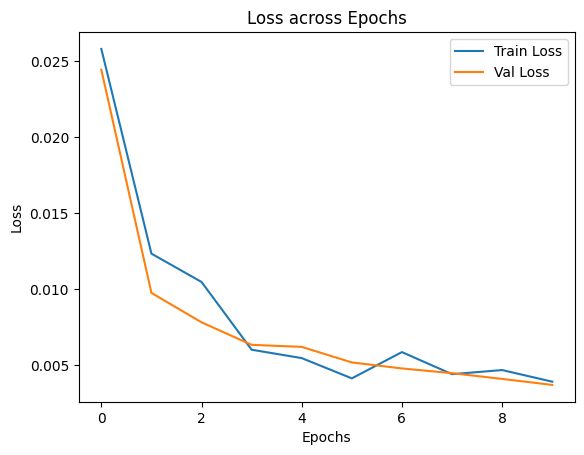

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9331602855288773


In [15]:
### Hyperparameters ###
tag = "bi_lstm_run_3"
early_stop = True
dropout_rate=0.5
num_epochs=10
lr_rate=1e-3

### Streamlined training of model + SVM ###
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
train_losses, val_losses = train_model(encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
plot_loss_graph(train_losses, val_losses, tag)
encoded_data, labels = encode_data(tag, encoder_ver)
svm_classifier = train_svm(encoded_data, labels.ravel(), tag, encoder_ver)

In [16]:
### Test SVM + Encoder ###
def test_model(tag, encoder_ver):
    test_dataset = CustomDataset("test", dataset_ver)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    # Load the saved models
    encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_Autoencoder.pt')
    encoder.eval()
    with open(f'ML_Models/{dataset_ver}_{encoder_ver}_{tag}_svm_classifier.pkl', 'rb') as file:
        svm_classifier = pickle.load(file)

    test_encoded_data = []
    test_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            X_batch, y_batch = batch
            X = X_batch.to(device)
            y = y_batch.to(device).reshape(-1, 1)

            test_encoded_batch = encoder.encoder(X)
            # print(encoded_batch.shape)
            
            ### for unidirectional LSTM ###
            # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])
            
            ### bidirectional LSTM have hidden states in 2 dimensions ###
            # h_1, h_2 = encoded_batch[0], encoded_batch[1]
            # encoded_batch = torch.cat((h_1, h_2), 1)
            
            test_encoded_data.append(test_encoded_batch)
            test_labels.append(y)

        test_encoded_data = torch.cat(test_encoded_data, 0).cpu()
        test_labels = torch.cat(test_labels, 0).cpu()   

    print(f'{test_encoded_data.shape=}')
    print(f'{test_labels.shape=}')

    test_predictions = svm_classifier.predict(test_encoded_data)
    print(f'{test_predictions.shape=}')
    return test_labels, test_predictions

In [17]:
def calculate_accuracy(test_labels, test_predictions, tag):
    # Calculate accuracy score
    accuracy = accuracy_score(test_labels, test_predictions)
    accuracy_percentage = accuracy * 100
    print(f"Accuracy: {accuracy_percentage:.2f}%")
    with open(f"logs/losses_{tag}.txt", "a") as file:
        file.write(f"SVM Test Accuracy: {accuracy_percentage:.2f}%\n")


    # Create a confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues')

    # Add labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'images/cm_{tag}.png')
    plt.show()

  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 93.73%


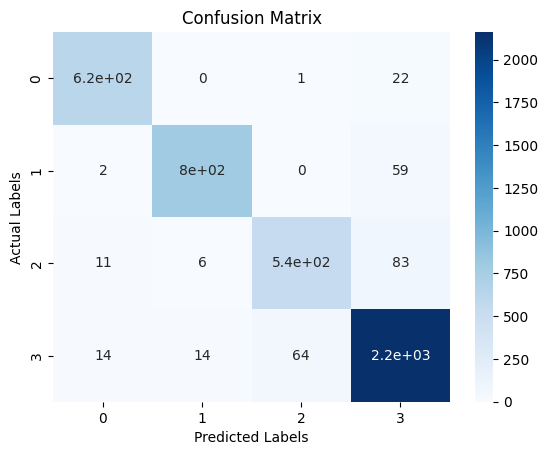

In [18]:
### Streamlined testing of model + SVM ###
test_labels, test_predictions = test_model(tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)